# 1. This notebook is used to train a Neural Network on the Digits dataset using first scikit MLPClassifier and then RO algorithms.

In [290]:
from IPython.core.display import display, HTML # for some notebook formatting.

import mlrose_hiive
import numpy as np
import logging
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd


from ast import literal_eval
import chess

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from mlrose_hiive import QueensGenerator, MaxKColorGenerator, TSPGenerator
from mlrose_hiive import SARunner, GARunner, MIMICRunner, RHCRunner, SKMLPRunner

from util.utils import run_experiment_multi_seed, runner_results_to_stats, plot_fitness_iteration, get_optimal_hyperparameters
from util.utils import plot_fitness_vs_hyperparameter, plot_HP_heatmap, plot_fitness_fevals, get_kcolor, get_perf_stats
from util.utils import train_model, fit_multiple_seeds

# switch off the chatter
logging.basicConfig(level=logging.WARNING)


%load_ext autoreload
%autoreload 2

from util.utils import *
from sklearn.neural_network import MLPClassifier

FIXED_SEED = 42
RANDOM_SEEDS = [1,2,3,4,5]
np.random.seed(FIXED_SEED)

df = load_titanic()
# df = load_hand_written_digits()


# Split the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.2, random_state=FIXED_SEED, shuffle=True, stratify=df['target'])

# Preprocess the data for kNN classifier
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Find results from A1

In [291]:
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Split your training data into a smaller training set and a validation set
X_train_small, X_val, y_train_small, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=FIXED_SEED)

# Initialize the MLPClassifier
mlp_model = MLPClassifier(
    random_state=FIXED_SEED,
    max_iter=1, 
    warm_start=True, 
    hidden_layer_sizes=(64),
    learning_rate_init=0.001,
    solver='sgd')

train_loss = []
val_loss = []
train_acc = []
val_acc = []

# Manually create the epochs loop
for _ in tqdm(range(1000)):
    mlp_model.fit(X_train_small, y_train_small)
    
    # Get the loss on the training set
    train_loss.append(mlp_model.loss_)
    
    # Get the predictions on the validation set
    y_val_pred = mlp_model.predict_proba(X_val)
    
    # Calculate the loss on the validation set
    val_loss.append(log_loss(y_val, y_val_pred))

    # Get the training accuracy
    y_train_pred = mlp_model.predict(X_train_small)
    train_acc.append(accuracy_score(y_train_small, y_train_pred))

    # Get the validation accuracy
    y_val_pred = mlp_model.predict(X_val)
    val_acc.append(accuracy_score(y_val, y_val_pred))


100%|██████████| 1000/1000 [00:17<00:00, 58.54it/s]


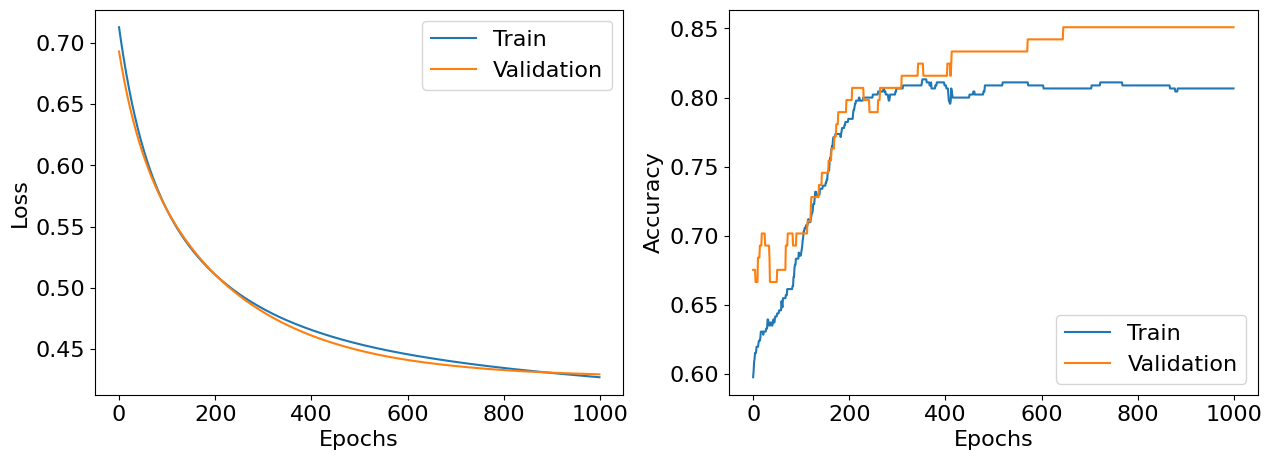

In [54]:

# Plot the training and validation loss curves as well as the training and validation accuracies using subplot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# increase font size
plt.rcParams.update({'font.size': 16})
axes[0].plot(train_loss)
axes[0].plot(val_loss)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend(['Train', 'Validation'])

axes[1].plot(train_acc)
axes[1].plot(val_acc)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend(['Train', 'Validation'])

plt.savefig('figures/NN_SGD_loss_acc.pdf', format='pdf', bbox_inches='tight')

In [41]:
import time 
from sklearn.metrics import make_scorer, f1_score
scorer = make_scorer(f1_score, average='weighted')

mlp_model = MLPClassifier(random_state=FIXED_SEED, max_iter=1000)
start = time.time()
mlp_model.fit(X_train_scaled, y_train)
end = time.time()
print(f"Training time: {(end - start) * 1000} ms")
# print crossval scores
from sklearn.model_selection import cross_val_score
scores = cross_val_score(mlp_model, X_train_scaled, y_train, cv=5, scoring=scorer)
print(scores.mean(), scores.std())

Training time: 2686.084270477295 ms
0.8012800392656372 0.02497333767676862


In [44]:
# train on whole training set
mlp_model.fit(X_train_scaled, y_train)
y_test_pred = mlp_model.predict(X_test_scaled)
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred)}")
print(f"Test f1 score: {f1_score(y_test, y_test_pred, average='weighted')}")

Test accuracy: 0.7972027972027972
Test f1 score: 0.7974694601913537


# 2. Random Optimization PlayGround

## 2.1 Tried weird mlrose

In [12]:
# ensure defaults are in grid search
default_grid_search_parameters = {
    'max_iters': [1000],
    'learning_rate_init': [0.1],
    'hidden_layer_sizes': [[64]],
    'activation': [mlrose_hiive.neural.activation.relu],
}

default_parameters = {
    'seed': 123456,
    'iteration_list': 2 ** np.arange(11),
    'max_attempts': 1000,
    'override_ctrl_c_handler': False, # required for running in notebook
    'n_jobs':1,
    'cv':5,
}


In [31]:
skmlp_grid_search_parameters = {
    **default_grid_search_parameters,
    'max_iters': [1000],
    'learning_rate_init': [0.5, 0.1, 0.01],
    'activation': [mlrose_hiive.neural.activation.relu],
    'random_state': RANDOM_SEEDS
}

skmlp_default_parameters = {
    **default_parameters,
    'early_stopping':False,
    'tol':1e-05,
    'alpha':0.001,
    'solver':'sgd',
    'grid_search_scorer_method': accuracy_score
}

In [32]:
cx_skr = SKMLPRunner(x_train=X_train_scaled, y_train=y_train,
                  x_test=X_test_scaled, y_test=y_test,
                  experiment_name='skmlp_clean',
                  grid_search_parameters = skmlp_grid_search_parameters,
                  **skmlp_default_parameters, generate_curves=True)

run_stats_df, curves_df, cv_results_df, cx_sr = cx_skr.run()

Fitting 5 folds for each of 15 candidates, totalling 75 fits


ValueError: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/mlrose_hiive/runners/skmlp_runner.py", line 56, in fit
    return self.mlp.fit(x_train, y_train)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'solver' parameter of MLPClassifier must be a str among {'adam', 'sgd', 'lbfgs'}. Got 'random_hill_climb' instead.


In [30]:
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_hidden_layer_sizes,param_learning_rate_init,param_max_iter,param_random_state,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.749151,0.111370,0.001663,0.000123,relu,[64],0.50,1000,1,"{'activation': 'relu', 'hidden_layer_sizes': [...",...,0.750411,0.031896,15,0.846154,0.934066,0.936264,0.927473,0.921053,0.913002,0.033846
1,2.711899,0.436953,0.002209,0.000214,relu,[64],0.50,1000,2,"{'activation': 'relu', 'hidden_layer_sizes': [...",...,0.764415,0.037177,14,0.925275,0.927473,0.925275,0.916484,0.916667,0.922234,0.004690
2,2.834059,0.182095,0.002294,0.000238,relu,[64],0.50,1000,3,"{'activation': 'relu', 'hidden_layer_sizes': [...",...,0.778420,0.046445,10,0.920879,0.927473,0.945055,0.934066,0.885965,0.922687,0.020022
3,2.764468,0.300222,0.002174,0.000089,relu,[64],0.50,1000,4,"{'activation': 'relu', 'hidden_layer_sizes': [...",...,0.774973,0.055422,11,0.923077,0.927473,0.947253,0.920879,0.918860,0.927508,0.010278
4,2.648732,0.299293,0.002165,0.000020,relu,[64],0.50,1000,5,"{'activation': 'relu', 'hidden_layer_sizes': [...",...,0.783729,0.060364,9,0.918681,0.929670,0.929670,0.929670,0.925439,0.926626,0.004297
5,2.954588,0.100892,0.002298,0.000194,relu,[64],0.10,1000,1,"{'activation': 'relu', 'hidden_layer_sizes': [...",...,0.766170,0.041945,13,0.896703,0.909890,0.916484,0.916484,0.925439,0.913000,0.009531
6,2.916101,0.220689,0.002326,0.000295,relu,[64],0.10,1000,2,"{'activation': 'relu', 'hidden_layer_sizes': [...",...,0.774942,0.032560,12,0.912088,0.907692,0.923077,0.920879,0.914474,0.915642,0.005655
7,3.393809,0.555513,0.002171,0.000113,relu,[64],0.10,1000,3,"{'activation': 'relu', 'hidden_layer_sizes': [...",...,0.787254,0.034632,7,0.903297,0.905495,0.916484,0.927473,0.896930,0.909935,0.010802
8,2.315199,0.213202,0.002143,0.000078,relu,[64],0.10,1000,4,"{'activation': 'relu', 'hidden_layer_sizes': [...",...,0.783745,0.037242,8,0.918681,0.916484,0.923077,0.912088,0.925439,0.919154,0.004736
9,2.700242,0.562693,0.002130,0.000039,relu,[64],0.10,1000,5,"{'activation': 'relu', 'hidden_layer_sizes': [...",...,0.797811,0.037325,6,0.918681,0.912088,0.936264,0.927473,0.914474,0.921796,0.008934


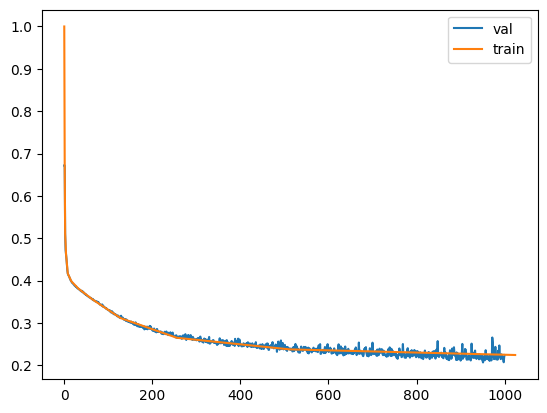

In [16]:
plt.plot(curves_df['Iteration'], curves_df['Fitness'], label="val")
plt.plot(run_stats_df['Iteration'], run_stats_df['Fitness'], label='train')
plt.legend()

## 2.2 Use my own implementation

In [34]:
from sklearn.model_selection import GridSearchCV
from mlrose_hiive import NeuralNetwork
from sklearn.metrics import accuracy_score

# scorer = make_scorer(f1_score, average='weighted')

param_grid = {
    'hidden_nodes': [[64]],
    'activation': ['relu'],
    'algorithm': ['random_hill_climb'],
    'max_iters': [5000],
    'bias': [True],
    'is_classifier': [True],
    'learning_rate': [0.1, 0.01, 0.001],
    'curve': ['True'],
    'early_stopping': [True],
    'max_attempts': [500],
    'random_state': RANDOM_SEEDS,
    'restarts': [0],
}

grid_search_rhc = GridSearchCV(estimator = NeuralNetwork(), param_grid = param_grid, scoring=accuracy_score, cv=5, n_jobs=-1, verbose=10)

grid_search_rhc.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[CV 2/5; 1/15] START activation=relu, algorithm=random_hill_climb, bias=True, curve=True, early_stopping=True, hidden_nodes=[64], is_classifier=True, learning_rate=0.1, max_attempts=500, max_iters=5000, random_state=1, restarts=0
[CV 1/5; 1/15] START activation=relu, algorithm=random_hill_climb, bias=True, curve=True, early_stopping=True, hidden_nodes=[64], is_classifier=True, learning_rate=0.1, max_attempts=500, max_iters=5000, random_state=1, restarts=0
[CV 3/5; 2/15] START activation=relu, algorithm=random_hill_climb, bias=True, curve=True, early_stopping=True, hidden_nodes=[64], is_classifier=True, learning_rate=0.1, max_attempts=500, max_iters=5000, random_state=2, restarts=0
[CV 5/5; 1/15] START activation=relu, algorithm=random_hill_climb, bias=True, curve=True, early_stopping=True, hidden_nodes=[64], is_classifier=True, learning_rate=0.1, max_attempts=500, max_iters=5000, random_state=1, restarts=0
[CV 4/5; 1/15] START activation=relu, algorithm=random_hill_climb, bias=True, cu

GridSearchCV(cv=5, estimator=NeuralNetwork(hidden_nodes=[]), n_jobs=-1,
             param_grid={'activation': ['relu'],
                         'algorithm': ['random_hill_climb'], 'bias': [True],
                         'curve': ['True'], 'early_stopping': [True],
                         'hidden_nodes': [[64]], 'is_classifier': [True],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_attempts': [500], 'max_iters': [5000],
                         'random_state': [1, 2, 3, 4, 5], 'restarts': [0]},
             scoring=<function accuracy_score at 0x7f4be9483380>, verbose=10)

In [39]:
# print best params
print(grid_search_rhc.best_params_)
# print(grid_search_rhc.best_score_)

# train on whole training set
rhc_model = grid_search_rhc.best_estimator_
print(rhc_model)
rhc_model.fit(X_train_scaled, y_train)

{'activation': 'relu', 'algorithm': 'random_hill_climb', 'bias': True, 'curve': 'True', 'early_stopping': True, 'hidden_nodes': [64], 'is_classifier': True, 'learning_rate': 0.1, 'max_attempts': 500, 'max_iters': 5000, 'random_state': 1, 'restarts': 0}
NeuralNetwork(curve='True', early_stopping=True, hidden_nodes=[64],
              max_attempts=500, max_iters=5000, random_state=1)
Test accuracy: 0.7902097902097902
Test log loss: 7.561605606108494


In [42]:
rhc_loss = pd.DataFrame(rhc_model.fitness_curve, columns=['Fitness', 'FEvals'])
y_test_pred = rhc_model.predict(X_test_scaled)
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred)}")
print(f"Test log loss: {log_loss(y_test, y_test_pred)}")

Test accuracy: 0.7902097902097902
Test log loss: 7.561605606108494


Text(0, 0.5, 'Fitness')

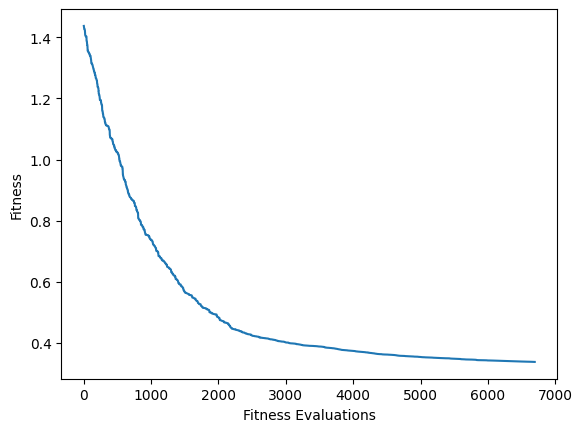

In [45]:
# plot fitness curve
# plt.plot(rhc_loss['fitness'])
plt.plot(rhc_loss['FEvals'], rhc_loss['Fitness'])
plt.xlabel('Fitness Evaluations')
plt.ylabel('Fitness')


In [57]:
rhc_model_01 = NeuralNetwork(curve=True, max_iters=5000, max_attempts=500,bias=True,  learning_rate=0.1, early_stopping=True, hidden_nodes=[64], algorithm='random_hill_climb')
losses01, scores01 = fit_multiple_seeds(rhc_model, X_train_scaled, y_train, X_test_scaled, y_test, RANDOM_SEEDS)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [01:38<00:00, 19.60s/it]


In [62]:
rhc_model_1 = NeuralNetwork(curve=True, max_iters=5000, max_attempts=500,bias=True,  learning_rate=1, early_stopping=True, hidden_nodes=[64], algorithm='random_hill_climb')
losses1, scores1 = fit_multiple_seeds(rhc_model_1, X_train_scaled, y_train, X_test_scaled, y_test, RANDOM_SEEDS)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [01:41<00:00, 20.32s/it]


In [79]:
rhc_model_2 = NeuralNetwork(curve=True, max_iters=2000, max_attempts=500,bias=True,  learning_rate=2, early_stopping=True, hidden_nodes=[64], algorithm='random_hill_climb')
losses2, scores2 = fit_multiple_seeds(rhc_model_2, X_train_scaled, y_train, X_test_scaled, y_test, RANDOM_SEEDS)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:32<00:00,  6.56s/it]


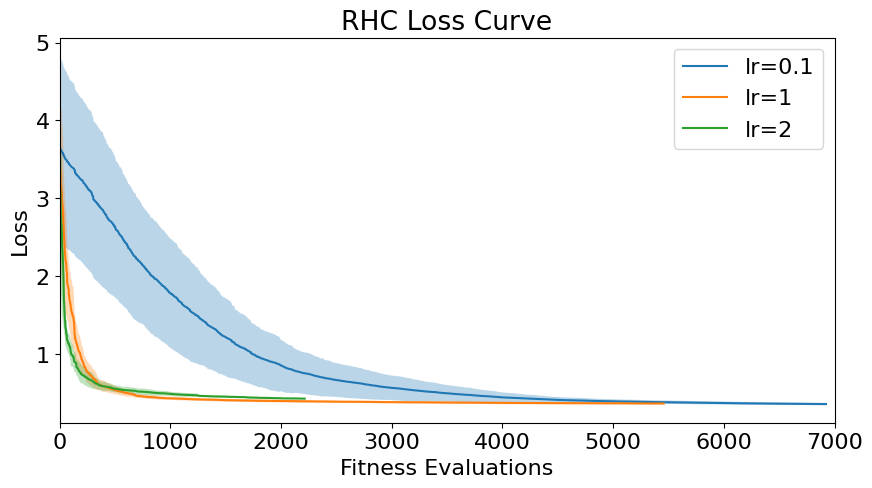

In [91]:
def mean_losses(losses):
    loss = np.array(losses)
    return np.mean(loss, axis=0)

def std_losses(losses):
    loss = np.array(losses)
    return np.std(loss, axis=0)

mean_rhc_loss_1 = pd.DataFrame(mean_losses(losses1), columns=['Fitness', 'FEvals'])
std_rhc_loss_1 = pd.DataFrame(std_losses(losses1), columns=['Fitness', 'FEvals'])

mean_rhc_loss_01 = pd.DataFrame(mean_losses(losses01), columns=['Fitness', 'FEvals'])
std_rhc_loss_01 = pd.DataFrame(std_losses(losses01), columns=['Fitness', 'FEvals'])

mean_rhc_loss_2 = pd.DataFrame(mean_losses(losses2), columns=['Fitness', 'FEvals'])
std_rhc_loss_2 = pd.DataFrame(std_losses(losses2), columns=['Fitness', 'FEvals'])


plt.figure(figsize=(10, 5))
plt.xlim(0, 7000)
plt.plot(mean_rhc_loss_01['FEvals'], mean_rhc_loss_01['Fitness'], label='lr=0.1')
plt.fill_between(mean_rhc_loss_01['FEvals'], mean_rhc_loss_01['Fitness'] - std_rhc_loss_01['Fitness'], mean_rhc_loss_01['Fitness'] + std_rhc_loss_01['Fitness'], alpha=0.3)
plt.plot(mean_rhc_loss_1['FEvals'], mean_rhc_loss_1['Fitness'], label='lr=1')
plt.fill_between(mean_rhc_loss_1['FEvals'], mean_rhc_loss_1['Fitness'] - std_rhc_loss_1['Fitness'], mean_rhc_loss_1['Fitness'] + std_rhc_loss_1['Fitness'], alpha=0.3)
plt.plot(mean_rhc_loss_2['FEvals'], mean_rhc_loss_2['Fitness'], label='lr=2')
plt.fill_between(mean_rhc_loss_2['FEvals'], mean_rhc_loss_2['Fitness'] - std_rhc_loss_2['Fitness'], mean_rhc_loss_2['Fitness'] + std_rhc_loss_2['Fitness'], alpha=0.3)
plt.title('RHC Loss Curve')
plt.xlabel('Fitness Evaluations')
plt.ylabel('Loss')
plt.legend()
plt.savefig('figures/NN_RHC_loss_curve.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [105]:
mean_rhc_loss_01

,Fitness,FEvals
0,3.658034,1.6
1,3.655637,3.0
2,3.637788,4.8
3,3.636993,6.0
4,3.636993,7.0
...,...,...
4995,0.356984,6917.4
4996,0.356983,6918.6
4997,0.356890,6920.0
4998,0.356881,6921.4


In [109]:
import time
start = time.time()
rhc_model_01.fit(X_train_scaled, y_train)
end = time.time()
print(f"Training time: {(end - start) * 1000} ms")

Training time: 13396.640539169312 ms


In [83]:
y_test_pred = rhc_model_2.predict(X_test_scaled)
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred)}")
print(f"Test log loss: {log_loss(y_test, y_test_pred)}")

Test accuracy: 0.7342657342657343
Test log loss: 9.578033767737427


In [128]:
sa_model_temp_1 = NeuralNetwork(curve=True, 
                         max_iters=5000, 
                         max_attempts=500,
                         bias=True,  
                         learning_rate=0.1, 
                         early_stopping=True, 
                         hidden_nodes=[64], 
                         algorithm='simulated_annealing', 
                         schedule=mlrose_hiive.GeomDecay(1.0, 0.99, 1e-8)
                         )

losses1, scores1 = fit_multiple_seeds(sa_model_temp_1, X_train_scaled, y_train, X_test_scaled, y_test, RANDOM_SEEDS)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [01:31<00:00, 18.32s/it]


In [189]:
temperatures = [1.0, 3.0, 5.0, 10.0, 20.0]
losses = []
scores = []

for temp in temperatures:
    
    sa_model_temp = NeuralNetwork(curve=True, 
                         max_iters=5000, 
                         max_attempts=500,
                         bias=True,  
                         learning_rate=0.1, 
                         early_stopping=True, 
                         hidden_nodes=[64], 
                         algorithm='simulated_annealing', 
                         schedule=mlrose_hiive.ArithDecay(temp, 0.99, 1e-8)
                         )
    
    loss, score = fit_multiple_seeds(sa_model_temp, X_train_scaled, y_train, X_test_scaled, y_test, RANDOM_SEEDS)
    losses.append(loss)
    scores.append(score)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [01:54<00:00, 22.91s/it]


In [190]:
# for each losses in losses, calculate mean and std
mean_losses_sa = [mean_losses(loss) for loss in losses]
std_losses_sa = [std_losses(loss) for loss in losses]

In [191]:
mean_losses_sa[0]

array([[3.65930362e+00, 3.00000000e+00],
       [3.65470587e+00, 5.00000000e+00],
       [3.65383826e+00, 6.40000000e+00],
       ...,
       [3.58526639e-01, 6.93960000e+03],
       [3.58509837e-01, 6.94120000e+03],
       [3.58460880e-01, 6.94280000e+03]])

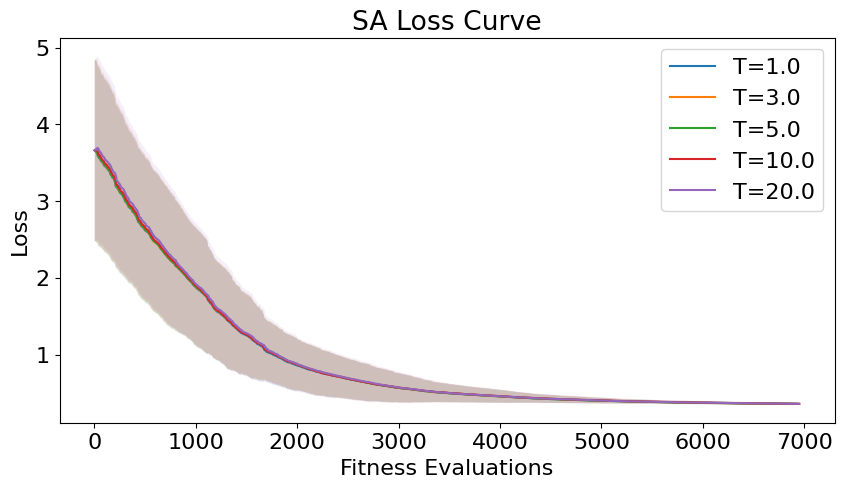

In [192]:
# Plot the mean and std of the losses for each temperature
plt.figure(figsize=(10, 5))
# plt.xlim(0, 7000)
for i, temp in enumerate(temperatures):
    temp_df = pd.DataFrame(mean_losses_sa[i], columns=['Fitness', 'FEvals'])
    temp_std = pd.DataFrame(std_losses_sa[i], columns=['Fitness', 'FEvals'])
    plt.plot(temp_df['FEvals'], temp_df['Fitness'], label=f'T={temp}')
    plt.fill_between(temp_df['FEvals'], temp_df['Fitness'] - temp_std['Fitness'], temp_df['Fitness'] + temp_std['Fitness'], alpha=0.1)
plt.title('SA Loss Curve')
plt.xlabel('Fitness Evaluations')
plt.ylabel('Loss')
plt.legend()
plt.savefig('figures/NN_SA_loss_curve.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [195]:
sa_model_temp = NeuralNetwork(curve=True, 
                         max_iters=5000, 
                         max_attempts=500,
                         bias=True,  
                         learning_rate=0.1, 
                         early_stopping=True, 
                         hidden_nodes=[64], 
                         algorithm='simulated_annealing', 
                         schedule=mlrose_hiive.GeomDecay(1, 0.99, 1e-8)
                         )

import time
start = time.time()
sa_model_temp.fit(X_train_scaled, y_train)
end = time.time()

print(f"Training time: {(end - start) * 1000} ms")

y_test_pred = sa_model_temp.predict(X_test_scaled)
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred)}")

Training time: 24578.397035598755 ms
Test accuracy: 0.7832167832167832


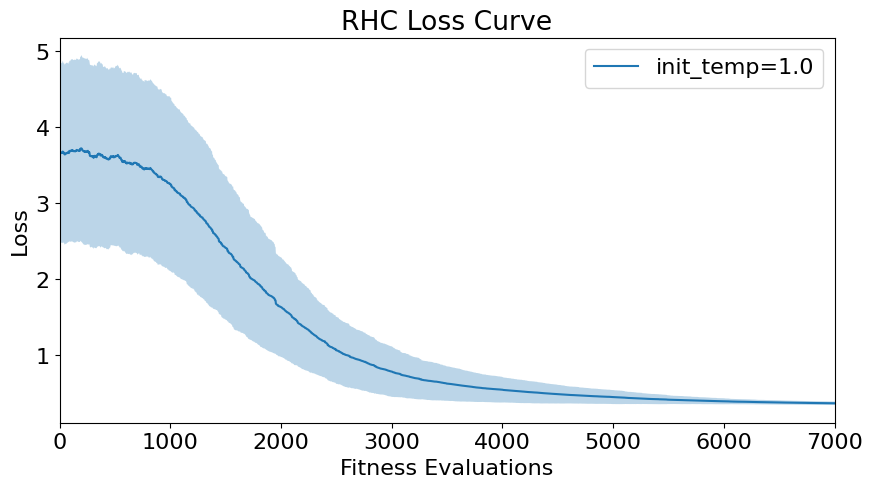

In [132]:
def mean_losses(losses):
    loss = np.array(losses)
    return np.mean(loss, axis=0)

def std_losses(losses):
    loss = np.array(losses)
    return np.std(loss, axis=0)

mean_sa_loss_1 = pd.DataFrame(mean_losses(losses1), columns=['Fitness', 'FEvals'])
std_sa_loss_1 = pd.DataFrame(std_losses(losses1), columns=['Fitness', 'FEvals'])



plt.figure(figsize=(10, 5))
plt.xlim(0, 7000)
plt.plot(mean_sa_loss_1['FEvals'], mean_sa_loss_1['Fitness'], label='init_temp=1.0')
plt.fill_between(mean_sa_loss_1['FEvals'], mean_sa_loss_1['Fitness'] - std_sa_loss_1['Fitness'], mean_sa_loss_1['Fitness'] + std_sa_loss_1['Fitness'], alpha=0.3)
plt.title('RHC Loss Curve')
plt.xlabel('Fitness Evaluations')
plt.ylabel('Loss')
plt.legend()
plt.savefig('figures/NN_RHC_loss_curve.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [129]:
from sklearn.model_selection import GridSearchCV
from mlrose_hiive import NeuralNetwork

scorer = make_scorer(f1_score, average='weighted')

param_grid = {
    'hidden_nodes': [[10]],
    'activation': ['relu'],
    'algorithm': ['genetic_alg'],
    'max_iters': [1000],
    'bias': [True],
    'is_classifier': [True],
    'learning_rate': [0.1],
    'curve': ['True'],
    'early_stopping': [True],
    'max_attempts': [100],
    'random_state': [0],
    'restarts': [0],
    'pop_size': [100, 200, 300],
    'mutation_prob': [0.1, 0.2, 0.3],
    
}

grid_search_ga = GridSearchCV(estimator = NeuralNetwork(), param_grid = param_grid, scoring=scorer, cv=5, n_jobs=-1, verbose=10)

grid_search_ga.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[CV 2/5; 2/9] START activation=relu, algorithm=genetic_alg, bias=True, curve=True, early_stopping=True, hidden_nodes=[10], is_classifier=True, learning_rate=0.1, max_attempts=100, max_iters=1000, mutation_prob=0.1, pop_size=200, random_state=0, restarts=0
[CV 1/5; 2/9] START activation=relu, algorithm=genetic_alg, bias=True, curve=True, early_stopping=True, hidden_nodes=[10], is_classifier=True, learning_rate=0.1, max_attempts=100, max_iters=1000, mutation_prob=0.1, pop_size=200, random_state=0, restarts=0
[CV 3/5; 1/9] START activation=relu, algorithm=genetic_alg, bias=True, curve=True, early_stopping=True, hidden_nodes=[10], is_classifier=True, learning_rate=0.1, max_attempts=100, max_iters=1000, mutation_prob=0.1, pop_size=100, random_state=0, restarts=0
[CV 4/5; 1/9] START activation=relu, algorithm=genetic_alg, bias=True, curve=True, early_stopping=True, hidden_nodes=[10], is_classifier=True, learning_rate=0.1, max_attempts=100, max_iters=1000, mutation_prob=0.1, pop_size=100, ran

GridSearchCV(cv=5, estimator=NeuralNetwork(hidden_nodes=[]), n_jobs=-1,
             param_grid={'activation': ['relu'], 'algorithm': ['genetic_alg'],
                         'bias': [True], 'curve': ['True'],
                         'early_stopping': [True], 'hidden_nodes': [[10]],
                         'is_classifier': [True], 'learning_rate': [0.1],
                         'max_attempts': [100], 'max_iters': [1000],
                         'mutation_prob': [0.1, 0.2, 0.3],
                         'pop_size': [100, 200, 300], 'random_state': [0],
                         'restarts': [0]},
             scoring=make_scorer(f1_score, average=weighted), verbose=10)

In [201]:
ga_model = NeuralNetwork(hidden_nodes=[64], 
                         activation='relu', 
                         algorithm='genetic_alg', 
                         max_iters=1000, 
                         bias=True, is_classifier=True, 
                         learning_rate=0.1, 
                         curve=True, 
                         early_stopping=True, 
                         max_attempts=100, 
                         random_state=0, 
                         restarts=0, 
                         pop_size=50, 
                         mutation_prob=0.1)

losses, scores = fit_multiple_seeds(ga_model, X_train_scaled, y_train, X_test_scaled, y_test, RANDOM_SEEDS)

100%|██████████| 5/5 [03:13<00:00, 38.65s/it]


In [207]:
dfs = []
for i, loss in enumerate(losses):
    df = pd.DataFrame(loss, columns=['Fitness', 'FEvals'])
    dfs.append(df)

In [226]:
# add padding to the dfs so they are all the same length (repeat last value)
max_len = max([len(df) for df in dfs])
# padding using pd.concat
dfs = [pd.concat([df, pd.DataFrame(df.iloc[[-1]].values.repeat(max_len - len(df), axis=0), columns=df.columns)], axis=0) if len(df) < max_len else df for df in dfs]
dfs = [df.reset_index(drop=True) for df in dfs]

# compute mean_df and std_df
mean_df = pd.concat(dfs).groupby(level=0).mean()
std_df = pd.concat(dfs).groupby(level=0).std()

Fitness       6.689297
FEvals     9975.600000
Name: 228, dtype: float64


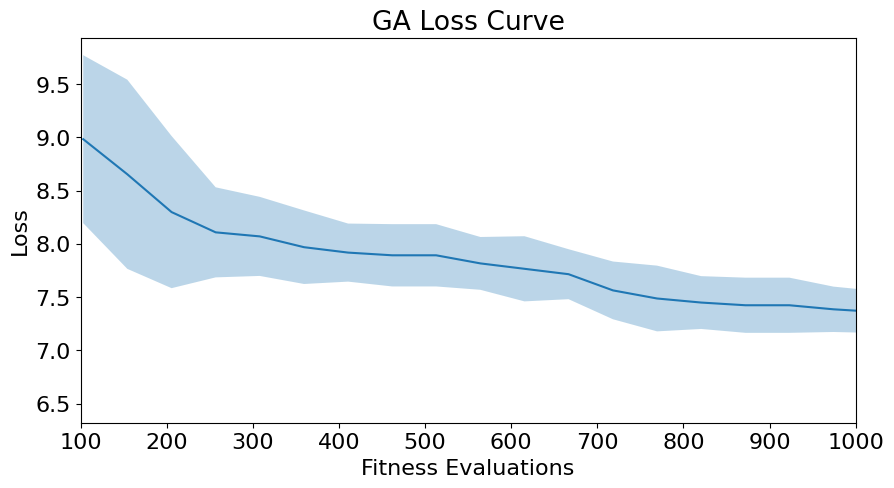

In [230]:
# print the last value of the mean_df
print(mean_df.iloc[-1])

plt.figure(figsize=(10, 5))
plt.xlim(100, 1000)
plt.plot(mean_df['FEvals'], mean_df['Fitness'])
plt.fill_between(mean_df['FEvals'], mean_df['Fitness'] - std_df['Fitness'], mean_df['Fitness'] + std_df['Fitness'], alpha=0.3)
plt.title('GA Loss Curve')
plt.xlabel('Fitness Evaluations')
plt.ylabel('Loss')
plt.show()

In [248]:
ga_model_20_01 = NeuralNetwork(hidden_nodes=[64], 
                         activation='relu', 
                         algorithm='genetic_alg', 
                         max_iters=1000, 
                         bias=True, is_classifier=True, 
                         learning_rate=0.1, 
                         curve=True, 
                         early_stopping=True, 
                         max_attempts=100, 
                         random_state=0, 
                         restarts=0, 
                         pop_size=20, 
                         mutation_prob=0.3)

losses_20_01, scores_20_01 = fit_multiple_seeds(ga_model_20_01, X_train_scaled, y_train, X_test_scaled, y_test, RANDOM_SEEDS)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [02:01<00:00, 24.34s/it]


In [249]:
dfs_20_01 = []
for i, loss in enumerate(losses):
    df = pd.DataFrame(loss, columns=['Fitness', 'FEvals'])
    dfs_20_01.append(df)

In [250]:
# add padding to the dfs so they are all the same length (repeat last value)
max_len = max([len(df) for df in dfs_20_01])
# padding using pd.concat
dfs_20_01 = [pd.concat([df, pd.DataFrame(df.iloc[[-1]].values.repeat(max_len - len(df), axis=0), columns=df.columns)], axis=0) if len(df) < max_len else df for df in dfs_20_01]
dfs_20_01 = [df.reset_index(drop=True) for df in dfs_20_01]

# compute mean_df and std_df
mean_df_20_01 = pd.concat(dfs_20_01).groupby(level=0).mean()
std_df_20_01 = pd.concat(dfs_20_01).groupby(level=0).std()

Fitness       6.689297
FEvals     9975.600000
Name: 228, dtype: float64


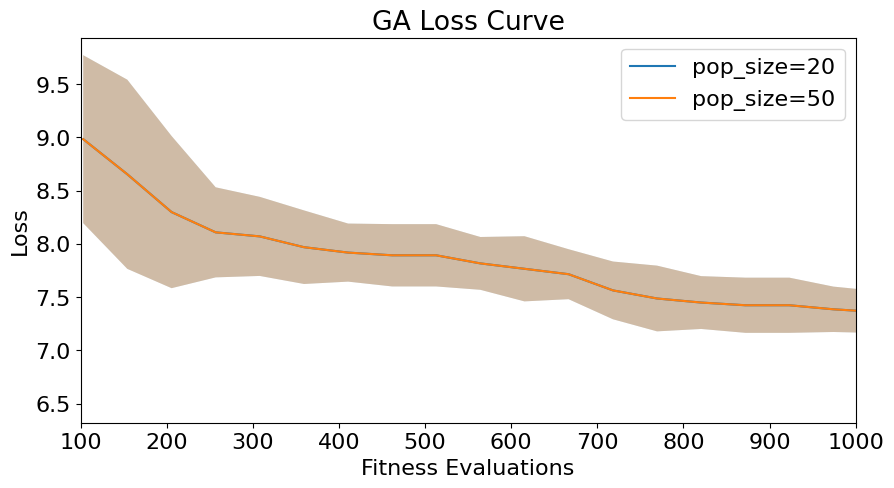

In [239]:
ga_model_5_01 = NeuralNetwork(hidden_nodes=[64],
                            activation='relu', 
                            algorithm='genetic_alg', 
                            max_iters=1000, 
                            bias=True, is_classifier=True, 
                            learning_rate=0.1, 
                            curve=True, 
                            early_stopping=True, 
                            max_attempts=100, 
                            random_state=0, 
                            restarts=0, 
                            pop_size=5, 
                            mutation_prob=0.1)

losses_5_01, scores_5_01 = fit_multiple_seeds(ga_model_5_01, X_train_scaled, y_train, X_test_scaled, y_test, RANDOM_SEEDS)

100%|██████████| 5/5 [00:35<00:00,  7.07s/it]


In [240]:
dfs_5_01 = []
for i, loss in enumerate(losses):
    df = pd.DataFrame(loss, columns=['Fitness', 'FEvals'])
    dfs_5_01.append(df)

# add padding to the dfs so they are all the same length (repeat last value)
max_len = max([len(df) for df in dfs_5_01])
# padding using pd.concat
dfs_5_01 = [pd.concat([df, pd.DataFrame(df.iloc[[-1]].values.repeat(max_len - len(df), axis=0), columns=df.columns)], axis=0) if len(df) < max_len else df for df in dfs_5_01]
dfs_5_01 = [df.reset_index(drop=True) for df in dfs_5_01]

# compute mean_df and std_df
mean_df_5_01 = pd.concat(dfs_5_01).groupby(level=0).mean()
std_df_5_01 = pd.concat(dfs_5_01).groupby(level=0).std()

Fitness       6.689297
FEvals     9975.600000
Name: 228, dtype: float64


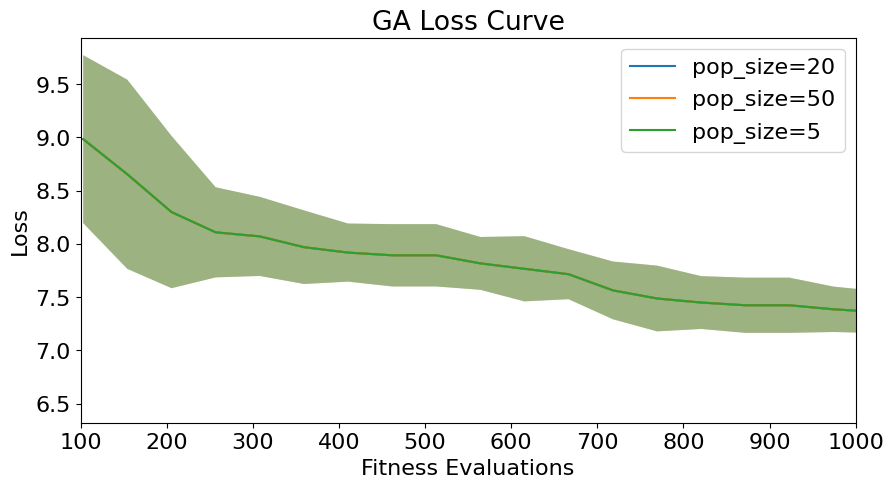

In [251]:
# print the last value of the mean_df
print(mean_df_20_01.iloc[-1])

plt.figure(figsize=(10, 5))
plt.xlim(100, 1000)
plt.plot(mean_df_20_01['FEvals'], mean_df_20_01['Fitness'], label='pop_size=20')
plt.fill_between(mean_df_20_01['FEvals'], mean_df_20_01['Fitness'] - std_df_20_01['Fitness'], mean_df_20_01['Fitness'] + std_df_20_01['Fitness'], alpha=0.3)
plt.plot(mean_df['FEvals'], mean_df['Fitness'], label='pop_size=50')
plt.fill_between(mean_df['FEvals'], mean_df['Fitness'] - std_df['Fitness'], mean_df['Fitness'] + std_df['Fitness'], alpha=0.3)
plt.plot(mean_df_5_01['FEvals'], mean_df_5_01['Fitness'], label='pop_size=5')
plt.fill_between(mean_df_5_01['FEvals'], mean_df_5_01['Fitness'] - std_df_5_01['Fitness'], mean_df_5_01['Fitness'] + std_df_5_01['Fitness'], alpha=0.3)
plt.title('GA Loss Curve')
plt.xlabel('Fitness Evaluations')
plt.ylabel('Loss')
plt.legend()
plt.savefig('figures/NN_GA_loss_curve.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [245]:
ga_model_1_01 = NeuralNetwork(hidden_nodes=[64],
                            activation='relu', 
                            algorithm='genetic_alg', 
                            max_iters=1000, 
                            bias=True, is_classifier=True, 
                            learning_rate=0.1, 
                            curve=True, 
                            early_stopping=True, 
                            max_attempts=100, 
                            random_state=0, 
                            restarts=0, 
                            pop_size=2, 
                            mutation_prob=0.1)

losses_1_01, scores_1_01 = fit_multiple_seeds(ga_model_1_01, X_train_scaled, y_train, X_test_scaled, y_test, RANDOM_SEEDS)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


In [246]:
dfs_1_01 = []
for i, loss in enumerate(losses):
    df = pd.DataFrame(loss, columns=['Fitness', 'FEvals'])
    dfs_1_01.append(df)

# add padding to the dfs so they are all the same length (repeat last value)
max_len = max([len(df) for df in dfs_1_01])
# padding using pd.concat
dfs_1_01 = [pd.concat([df, pd.DataFrame(df.iloc[[-1]].values.repeat(max_len - len(df), axis=0), columns=df.columns)], axis=0) if len(df) < max_len else df for df in dfs_1_01]
dfs_1_01 = [df.reset_index(drop=True) for df in dfs_1_01]

# compute mean_df and std_df
mean_df_1_01 = pd.concat(dfs_1_01).groupby(level=0).mean()
std_df_1_01 = pd.concat(dfs_1_01).groupby(level=0).std()

# print the last value of the mean_df
print(mean_df_1_01.iloc[-1])

Fitness       6.689297
FEvals     9975.600000
Name: 228, dtype: float64


Fitness       6.689297
FEvals     9975.600000
Name: 228, dtype: float64


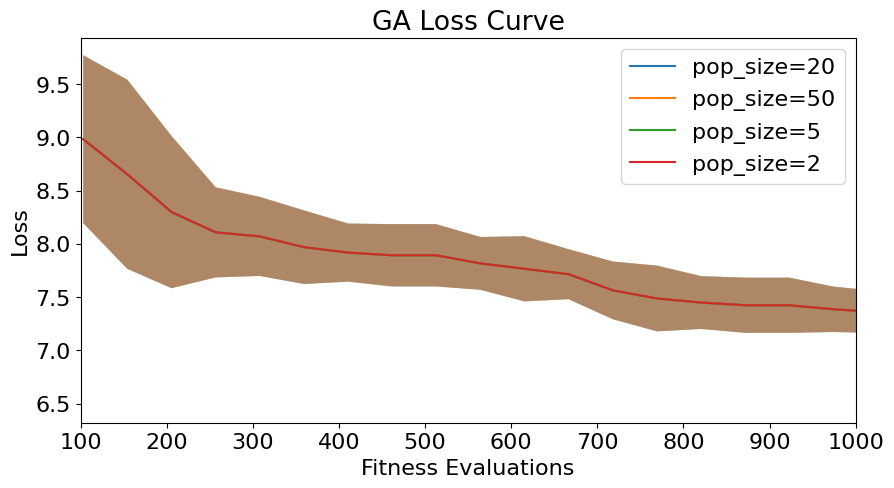

In [247]:
# print the last value of the mean_df
print(mean_df_20_01.iloc[-1])

plt.figure(figsize=(10, 5))
plt.xlim(100, 1000)
plt.plot(mean_df_20_01['FEvals'], mean_df_20_01['Fitness'], label='pop_size=20')
plt.fill_between(mean_df_20_01['FEvals'], mean_df_20_01['Fitness'] - std_df_20_01['Fitness'], mean_df_20_01['Fitness'] + std_df_20_01['Fitness'], alpha=0.3)
plt.plot(mean_df['FEvals'], mean_df['Fitness'], label='pop_size=50')
plt.fill_between(mean_df['FEvals'], mean_df['Fitness'] - std_df['Fitness'], mean_df['Fitness'] + std_df['Fitness'], alpha=0.3)
plt.plot(mean_df_5_01['FEvals'], mean_df_5_01['Fitness'], label='pop_size=5')
plt.fill_between(mean_df_5_01['FEvals'], mean_df_5_01['Fitness'] - std_df_5_01['Fitness'], mean_df_5_01['Fitness'] + std_df_5_01['Fitness'], alpha=0.3)
plt.plot(mean_df_1_01['FEvals'], mean_df_1_01['Fitness'], label='pop_size=2')
plt.fill_between(mean_df_1_01['FEvals'], mean_df_1_01['Fitness'] - std_df_1_01['Fitness'], mean_df_1_01['Fitness'] + std_df_1_01['Fitness'], alpha=0.3)
plt.title('GA Loss Curve')
plt.xlabel('Fitness Evaluations')
plt.ylabel('Loss')
plt.legend()
plt.savefig('figures/NN_GA_loss_curve.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [262]:
ga_model_100_01 = NeuralNetwork(hidden_nodes=[64],
                            activation='relu', 
                            algorithm='genetic_alg', 
                            max_iters=1000, 
                            bias=True, is_classifier=True, 
                            learning_rate=0.1, 
                            curve=True, 
                            early_stopping=True, 
                            max_attempts=100, 
                            random_state=1, 
                            restarts=0, 
                            pop_size=100, 
                            mutation_prob=0.1)

ga_model_100_01.fit(X_train_scaled, y_train)
y_test_pred = ga_model_100_01.predict(X_test_scaled)
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred)}")

Test accuracy: 0.7762237762237763


In [263]:
ga_model_50_01 = NeuralNetwork(hidden_nodes=[64],
                            activation='relu', 
                            algorithm='genetic_alg', 
                            max_iters=1000, 
                            bias=True, is_classifier=True, 
                            learning_rate=0.1, 
                            curve=True, 
                            early_stopping=True, 
                            max_attempts=100, 
                            random_state=1, 
                            restarts=0, 
                            pop_size=50, 
                            mutation_prob=0.1)

ga_model_100_01.fit(X_train_scaled, y_train)
y_test_pred = ga_model_100_01.predict(X_test_scaled)
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred)}")

Test accuracy: 0.7762237762237763


In [283]:
ga_model_25_01 = NeuralNetwork(hidden_nodes=[64],
                            activation='relu', 
                            algorithm='genetic_alg', 
                            max_iters=1000, 
                            bias=True, is_classifier=True, 
                            learning_rate=0.1, 
                            curve=True, 
                            early_stopping=True, 
                            max_attempts=200, 
                            random_state=1, 
                            restarts=0, 
                            pop_size=25, 
                            mutation_prob=0.1)

ga_model_25_01.fit(X_train_scaled, y_train)
y_test_pred = ga_model_25_01.predict(X_test_scaled)
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred)}")

Test accuracy: 0.8251748251748252


In [265]:
ga_model_10_01 = NeuralNetwork(hidden_nodes=[64],
                            activation='relu', 
                            algorithm='genetic_alg', 
                            max_iters=1000, 
                            bias=True, is_classifier=True, 
                            learning_rate=0.1, 
                            curve=True, 
                            early_stopping=True, 
                            max_attempts=100, 
                            random_state=1, 
                            restarts=0, 
                            pop_size=10, 
                            mutation_prob=0.1)

ga_model_10_01.fit(X_train_scaled, y_train)
y_test_pred = ga_model_10_01.predict(X_test_scaled)
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred)}")

Test accuracy: 0.7762237762237763


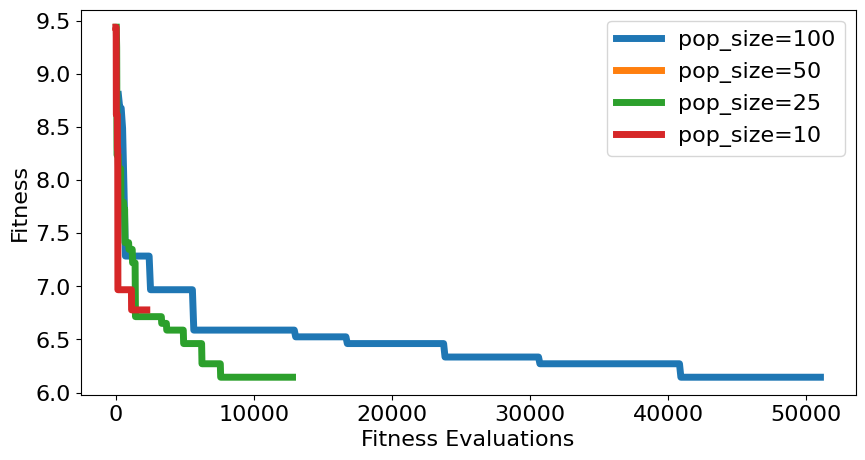

In [284]:
df_100_01 = pd.DataFrame(ga_model_100_01.fitness_curve, columns=['Fitness', 'FEvals'])
df_50_01 = pd.DataFrame(ga_model_50_01.fitness_curve, columns=['Fitness', 'FEvals'])
df_25_01 = pd.DataFrame(ga_model_25_01.fitness_curve, columns=['Fitness', 'FEvals'])
df_10_01 = pd.DataFrame(ga_model_10_01.fitness_curve, columns=['Fitness', 'FEvals'])
plt.figure(figsize=(10, 5))
plt.plot(df_100_01['FEvals'], df_100_01['Fitness'], label='pop_size=100', linewidth=5)
plt.plot(df_50_01['FEvals'], df_50_01['Fitness'], label='pop_size=50', linewidth=5)
plt.plot(df_25_01['FEvals'], df_25_01['Fitness'], label='pop_size=25', linewidth=5)
plt.plot(df_10_01['FEvals'], df_10_01['Fitness'], label='pop_size=10', linewidth=5)
plt.xlabel('Fitness Evaluations')
plt.ylabel('Fitness')
plt.legend()
plt.savefig('figures/NN_GA_loss_curve.pdf', format='pdf', bbox_inches='tight')


In [285]:
ga_model_25_005 = NeuralNetwork(hidden_nodes=[64],
                            activation='relu', 
                            algorithm='genetic_alg', 
                            max_iters=1000, 
                            bias=True, is_classifier=True, 
                            learning_rate=0.1, 
                            curve=True, 
                            early_stopping=True, 
                            max_attempts=100, 
                            random_state=1, 
                            restarts=0, 
                            pop_size=25, 
                            mutation_prob=0.05)

ga_model_25_005.fit(X_train_scaled, y_train)
y_test_pred = ga_model_25_005.predict(X_test_scaled)
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred)}")

Test accuracy: 0.7692307692307693


In [286]:
ga_model_25_015 = NeuralNetwork(hidden_nodes=[64],
                            activation='relu', 
                            algorithm='genetic_alg', 
                            max_iters=1000, 
                            bias=True, is_classifier=True, 
                            learning_rate=0.1, 
                            curve=True, 
                            early_stopping=True, 
                            max_attempts=100, 
                            random_state=1, 
                            restarts=0, 
                            pop_size=25, 
                            mutation_prob=0.15)

ga_model_25_015.fit(X_train_scaled, y_train)
y_test_pred = ga_model_25_015.predict(X_test_scaled)
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred)}")

Test accuracy: 0.7832167832167832


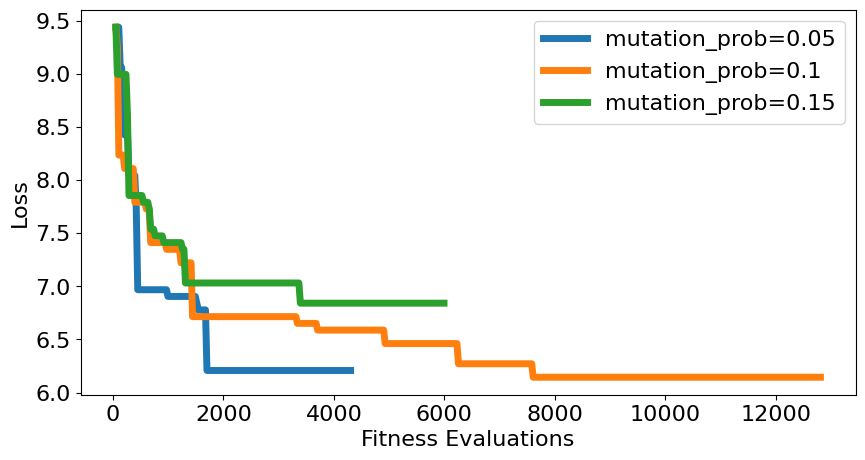

In [289]:
df_25_005 = pd.DataFrame(ga_model_25_005.fitness_curve, columns=['Fitness', 'FEvals'])
df_25_015 = pd.DataFrame(ga_model_25_015.fitness_curve, columns=['Fitness', 'FEvals'])
plt.figure(figsize=(10, 5))
plt.plot(df_25_005['FEvals'], df_25_005['Fitness'], label='mutation_prob=0.05', linewidth=5)
plt.plot(df_25_01['FEvals'], df_25_01['Fitness'], label='mutation_prob=0.1', linewidth=5)
plt.plot(df_25_015['FEvals'], df_25_015['Fitness'], label='mutation_prob=0.15', linewidth=5)
plt.xlabel('Fitness Evaluations')
plt.ylabel('Loss')
plt.legend()
plt.savefig('figures/NN_GA_loss_mutation.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [133]:
ga_model = grid_search_ga.best_estimator_
# ga_model.max_attempts = 300
ga_model
ga_losses, ga_scores = fit_multiple_seeds(ga_model, X_train_scaled, y_train, X_test_scaled, y_test, RANDOM_SEEDS)


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [03:26<00:00, 41.34s/it]


In [144]:
ga_losses_1 = pd.DataFrame(ga_losses[0], columns=['fitness', 'iteration'])
ga_losses_2 = pd.DataFrame(ga_losses[1], columns=['fitness', 'iteration'])
ga_losses_3 = pd.DataFrame(ga_losses[2], columns=['fitness', 'iteration'])
ga_losses_4 = pd.DataFrame(ga_losses[3], columns=['fitness', 'iteration'])
ga_losses_5 = pd.DataFrame(ga_losses[4], columns=['fitness', 'iteration'])

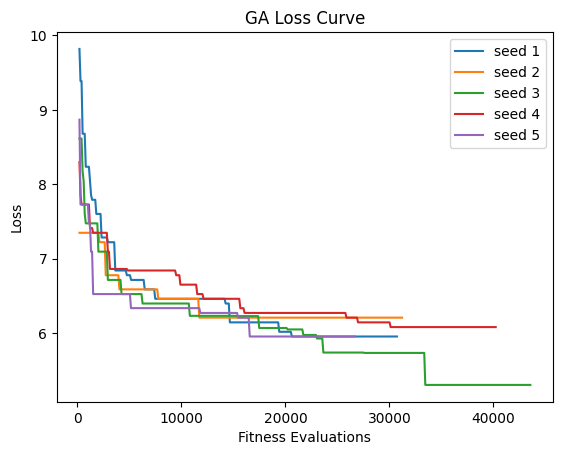

In [150]:
plt.figure()
plt.plot(ga_losses_1['iteration'], ga_losses_1['fitness'], label='seed 1')
plt.plot(ga_losses_2['iteration'], ga_losses_2['fitness'], label='seed 2')
plt.plot(ga_losses_3['iteration'], ga_losses_3['fitness'], label='seed 3')
plt.plot(ga_losses_4['iteration'], ga_losses_4['fitness'], label='seed 4')
plt.plot(ga_losses_5['iteration'], ga_losses_5['fitness'], label='seed 5')
# plt.fill_between(ga_losses_df['iteration'], ga_losses_df['fitness'] - ga_std_loss['fitness'], ga_mean_loss['fitness'] + ga_std_loss['fitness'], alpha=0.1)
plt.title('GA Loss Curve')
plt.xlabel('Fitness Evaluations')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [119]:
ga_model.fit(X_train_scaled, y_train)
y_test_pred = ga_model.predict(X_test_scaled)
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred)}")
print(f"Test f1 score: {f1_score(y_test, y_test_pred, average='weighted')}")
print(f"Test log loss: {log_loss(y_test, y_test_pred)}")

Test accuracy: 0.7832167832167832
Test f1 score: 0.7829081165465605
Test log loss: 7.813659126312111


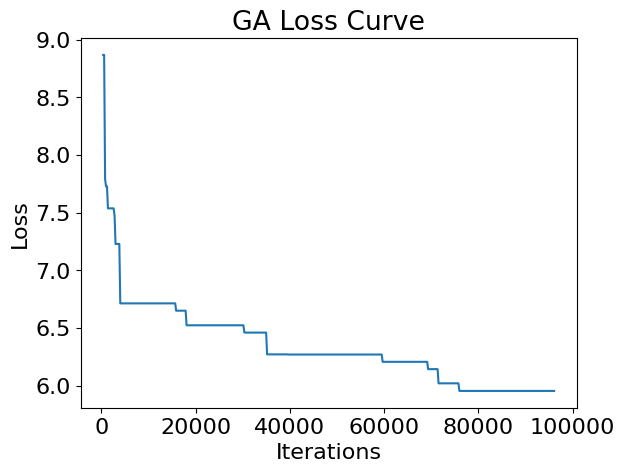

In [106]:
plt.figure()
plt.plot(ga_losses_df['iteration'], ga_losses_df['fitness'])
# plt.fill_between(ga_losses_df['iteration'], ga_losses_df['fitness'] - ga_std_loss['fitness'], ga_mean_loss['fitness'] + ga_std_loss['fitness'], alpha=0.1)
plt.title('GA Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()


In [115]:
from sklearn.model_selection import GridSearchCV
from mlrose_hiive import NeuralNetwork

scorer = make_scorer(f1_score, average='weighted')

param_grid = {
    'hidden_nodes': [[10]],
    'activation': ['relu'],
    'algorithm': ['simulated_annealing'],
    'max_iters': [1000],
    'bias': [True],
    'is_classifier': [True],
    'learning_rate': [0.1],
    'curve': ['True'],
    'early_stopping': [True],
    'max_attempts': [30],
    'random_state': [0],
    'restarts': [0],
    'schedule': [mlrose_hiive.GeomDecay(1.0, 0.99, 1e-8)]
    
}

grid_search_sa = GridSearchCV(estimator = NeuralNetwork(), param_grid = param_grid, scoring=scorer, cv=5, n_jobs=-1, verbose=10)

grid_search_sa.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 4/5; 1/1] START activation=relu, algorithm=simulated_annealing, bias=True, curve=True, early_stopping=True, hidden_nodes=[10], is_classifier=True, learning_rate=0.1, max_attempts=30, max_iters=1000, random_state=0, restarts=0, schedule=1.0
[CV 5/5; 1/1] START activation=relu, algorithm=simulated_annealing, bias=True, curve=True, early_stopping=True, hidden_nodes=[10], is_classifier=True, learning_rate=0.1, max_attempts=30, max_iters=1000, random_state=0, restarts=0, schedule=1.0
[CV 2/5; 1/1] START activation=relu, algorithm=simulated_annealing, bias=True, curve=True, early_stopping=True, hidden_nodes=[10], is_classifier=True, learning_rate=0.1, max_attempts=30, max_iters=1000, random_state=0, restarts=0, schedule=1.0
[CV 1/5; 1/1] START activation=relu, algorithm=simulated_annealing, bias=True, curve=True, early_stopping=True, hidden_nodes=[10], is_classifier=True, learning_rate=0.1, max_attempts=30, max_iters=1000, random

GridSearchCV(cv=5, estimator=NeuralNetwork(hidden_nodes=[]), n_jobs=-1,
             param_grid={'activation': ['relu'],
                         'algorithm': ['simulated_annealing'], 'bias': [True],
                         'curve': ['True'], 'early_stopping': [True],
                         'hidden_nodes': [[10]], 'is_classifier': [True],
                         'learning_rate': [0.1], 'max_attempts': [30],
                         'max_iters': [1000], 'random_state': [0],
                         'restarts': [0],
                         'schedule': [GeomDecay(init_temp=1.0, decay=0.99, min_temp=1e-08)]},
             scoring=make_scorer(f1_score, average=weighted), verbose=10)

In [116]:
sa_model = grid_search_sa.best_estimator_
sa_model
sa_losses, sa_scores = fit_multiple_seeds(sa_model, X_train_scaled, y_train, X_test_scaled, y_test, RANDOM_SEEDS)


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


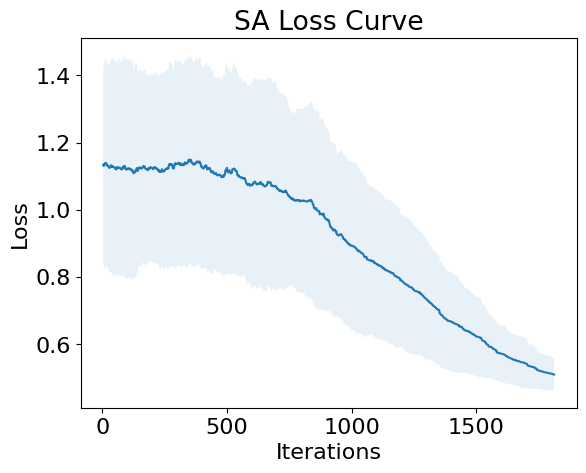

In [117]:
sa_mean_loss = pd.DataFrame(mean_losses(sa_losses), columns=['fitness', 'iteration'])
sa_std_loss = pd.DataFrame(std_losses(sa_losses), columns=['fitness', 'iteration'])

plt.figure()
plt.plot(sa_mean_loss['iteration'], sa_mean_loss['fitness'])
plt.fill_between(sa_mean_loss['iteration'], sa_mean_loss['fitness'] - sa_std_loss['fitness'], sa_mean_loss['fitness'] + sa_std_loss['fitness'], alpha=0.1)
plt.title('SA Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()


In [141]:
sa_model.fit(X_train_scaled, y_train)
y_test_pred = sa_model.predict(X_test_scaled)
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred)}")
print(f"Test f1 score: {f1_score(y_test, y_test_pred, average='weighted')}")
print(f"Test log loss: {log_loss(y_test, y_test_pred)}")

Test accuracy: 0.6993006993006993
Test f1 score: 0.6891620554986891
Test log loss: 10.838301368755507


# 3. Deep in the Serious Work

In [45]:
# Split your training data into a smaller training set and a validation set
X_train_small, X_val, y_train_small, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=FIXED_SEED)

In [114]:
from mlrose_hiive import NeuralNetwork
rhc_model = NeuralNetwork(curve=True, max_iters=1, max_attempts=500,bias=True,  learning_rate=0.1, early_stopping=True, hidden_nodes=[64], algorithm='random_hill_climb')
tl , vl, ts, vs = train_model(rhc_model, X_train_small, y_train_small, X_val, y_val, n_epochs=5000)


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [01:09<00:00, 71.48it/s] 


In [115]:
y_test_pred = rhc_model.predict(X_test_scaled)
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred)}")

Test accuracy: 0.7972027972027972


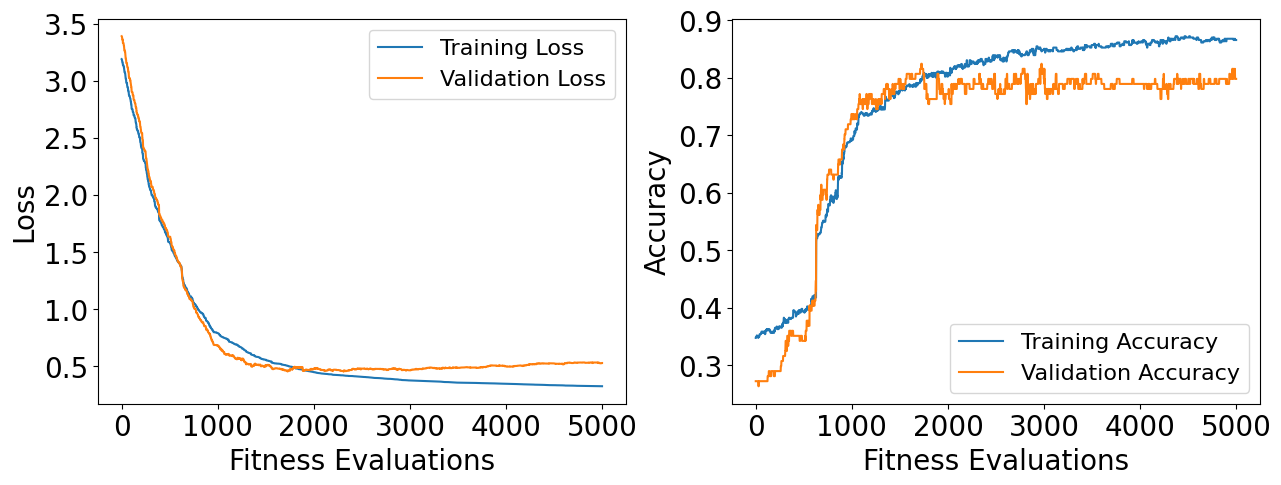

In [124]:
# suplot 1, 2

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# increase font size
plt.rcParams.update({'font.size': 16})
# increase font of the axes
for ax in axes:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)

axes[0].plot(tl, label='Training Loss')
axes[0].plot(vl, label='Validation Loss')
axes[0].set_xlabel('Fitness Evaluations')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(ts, label='Training Accuracy')
axes[1].plot(vs, label='Validation Accuracy')
axes[1].set_xlabel('Fitness Evaluations')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
plt.savefig('figures/NN_RHC_loss_acc.pdf', format='pdf', bbox_inches='tight')
plt.show()

# plt.figure()
# plt.plot(tl, label='Training Loss')
# plt.title('RHC Loss Curve')
# plt.xlabel('Iterations')
# plt.ylabel('Loss')
# plt.plot(vl, label='Validation Loss')
# plt.legend()
# plt.show()

# plt.figure()
# plt.plot(ts, label='Training Accuracy')
# plt.plot(vs, label='Validation Accuracy')
# plt.title('RHC Accuracy Curve')
# plt.xlabel('Iterations')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [60]:
from util.utils import train_model_SA
sa_nn = NeuralNetwork(curve=True, max_iters=1, max_attempts=1,bias=True,  learning_rate=0.1, early_stopping=True, hidden_nodes=[64], algorithm='simulated_annealing', schedule=mlrose_hiive.ArithDecay(1.0, 0.99, 1e-8))
tl , vl, ts, vs = train_model_SA(sa_nn, X_train_scaled, y_train, X_test_scaled, y_test, n_epochs=10000)

100%|██████████| 10000/10000 [02:21<00:00, 70.85it/s]


In [61]:
y_test_pred = sa_nn.predict(X_test_scaled)
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred)}")

Test accuracy: 0.7762237762237763


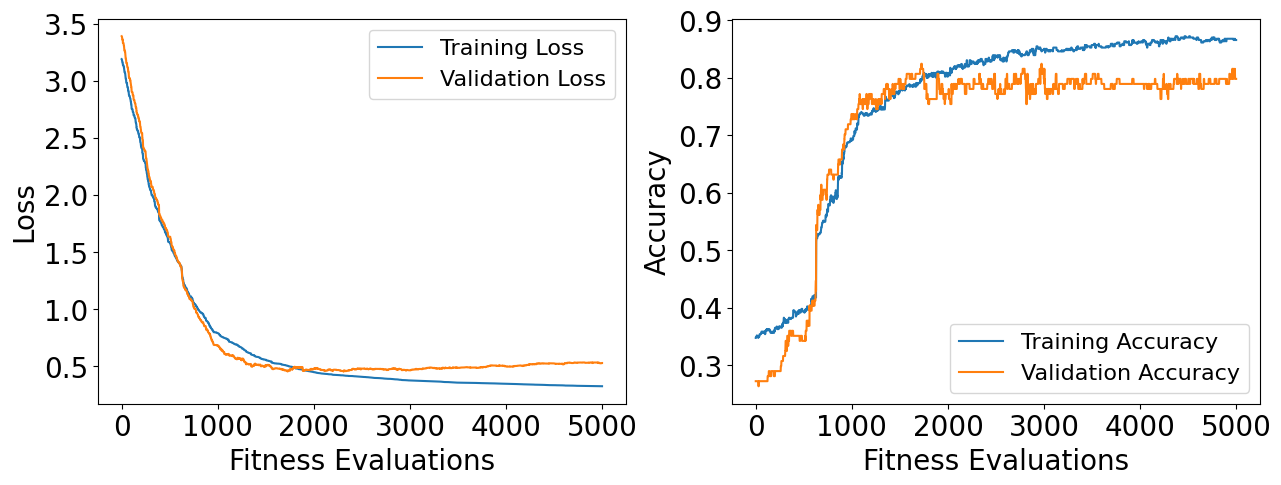

In [198]:
# plt.figure()
# plt.plot(tl, label='Training Loss')
# plt.title('SA Loss Curve')
# plt.xlabel('Iterations')
# plt.ylabel('Loss')
# plt.plot(vl, label='Validation Loss')
# plt.legend()
# plt.show()

# plt.figure()
# plt.plot(ts, label='Training Accuracy')
# plt.plot(vs, label='Validation Accuracy')
# plt.title('SA Accuracy Curve')
# plt.xlabel('Iterations')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# subplots 1 2
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# increase font size
plt.rcParams.update({'font.size': 16})
# increase font of the axes
for ax in axes:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)

axes[0].plot(tl, label='Training Loss')
axes[0].plot(vl, label='Validation Loss')
axes[0].set_xlabel('Fitness Evaluations')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(ts, label='Training Accuracy')
axes[1].plot(vs, label='Validation Accuracy')
axes[1].set_xlabel('Fitness Evaluations')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.savefig('figures/NN_SA_loss_acc.pdf', format='pdf', bbox_inches='tight')

plt.show()
